# Compute a p-value - look at the effect size

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as sst

from IPython.display import Image as Image
from IPython.display import display as display


## Create a normal distribution

In [53]:
np.random.seed(42) # 42 is arbitrary 

In [54]:
# define the normal 0,1 object
norm01 = sst.norm(0,1)
# Let's fix the seed of the random generator
sample_size = (30,)
sample = norm01.rvs(size=sample_size)


In [55]:
# compute mean and corrected standard deviation
sample_mean = sample.mean()
#sample_std_biased = sample.std()
sample_std = np.sqrt(np.var(sample, ddof=1))
# print(sample_std,sample_std_biased)
N = len(sample)

print("sample mean: ",sample_mean, "sample_std: ", sample_std)

sample mean:  -0.188146895851 sample_std:  0.900006427402


## compute the t-value and corresponding p-value

In [56]:
t_value = sample_mean / (sample_std/np.sqrt(N))
print(t_value)

-1.14501736704


In [57]:
def t_value_from_sample(sample):
    """
    """
    N = len(sample)
    sample_mean = sample.mean()
    sample_std = np.sqrt(np.var(sample,ddof=1))
    t_val = sample_mean / (sample_std/np.sqrt(N))
    return t_val
    

In [58]:
print(t_value_from_sample(sample))

-1.14501736704


In [59]:
N = len(sample)
p_val = sst.t.sf(t_value_from_sample(sample), df=N-1)
print(p_val)

0.869217926906


## Do this for a number of experiments

In [60]:
sample_size = 16
distrib = sst.norm(.22, 1)
nb_of_experiments = 20
alpha = 0.05

effect_size = []

for idx in range(nb_of_experiments):
    sample =  distrib.rvs(size=(sample_size,))
    t_val = t_value_from_sample(sample)
    p_val = sst.t.sf(t_value_from_sample(sample), df=sample_size-1)
    signif = int(p_val <= alpha)
    print(t_val, "\t\t", p_val,"\t",  "*"*signif, )
    if signif:
        effect_size.append(sample.mean())

print('\n Effect_size corresponding to "significant" p-values: \n', effect_size) 

-0.32479883629 		 0.625090484999 	 
1.25302676452 		 0.114688777064 	 
1.20926387017 		 0.122638560798 	 
0.799735869217 		 0.21817316536 	 
0.482269951176 		 0.318287947402 	 
1.53850408647 		 0.0723755097364 	 
0.0358540790042 		 0.48593575288 	 
0.972060129759 		 0.173217961464 	 
1.2906284685 		 0.108186008883 	 
1.50563025764 		 0.0764640116676 	 
0.720456183974 		 0.241160751255 	 
2.27538471379 		 0.0189933385076 	 *
0.470510453611 		 0.322379529233 	 
1.58437290083 		 0.0669805728906 	 
-0.748573848364 		 0.767154624327 	 
1.03260584691 		 0.159075494746 	 
1.65625970027 		 0.0592166309746 	 
4.29029344643 		 0.00032213201159 	 *
1.44745303547 		 0.0841732722974 	 
-0.693448209256 		 0.750686783723 	 

 Effect_size corresponding to "significant" p-values: 
 [0.73165060506054524, 0.63895489955170837]


In [61]:
print(np.asanyarray(effect_size).mean(), np.asanyarray(effect_size).std())

0.685302752306 0.0463478527544


## Relate this to bias and file drawer effect

# The p-hacking problem

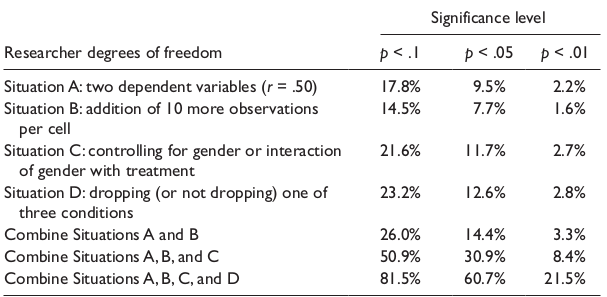

In [62]:
img = Image('./figures/simons_table.png')
display(img)

# Revise alpha 

### Recent and less recent attempts to change the standard alpha

Johnson, V.E. (2013). Revised standards for statistical evidence. PNAS 110, 19313–19317.


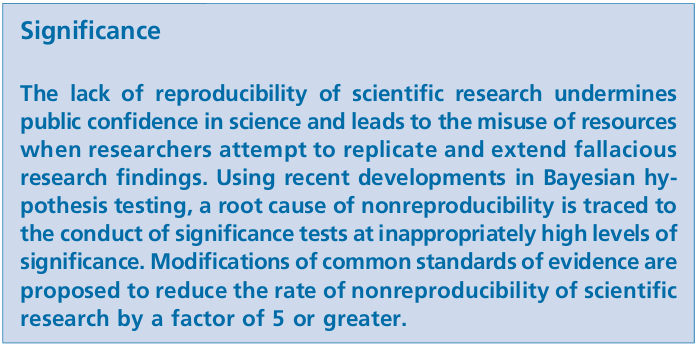

In [63]:
print("Johnson, V.E. (2013). Revised standards for statistical evidence. " + 
                             "PNAS 110, 19313–19317.")
Image('./figures/johnson_PNAS_2013_significance.png')


### Make $\alpha$ adapted to the problem at hand

This is going to be hard : cultural shift 

## Confidence intervals

In [64]:
def confidence_intervals(Nexp, **prmtrs):
    """
    Nexp: the number of experiments done
    prmtrs: a dictionary with our parameters, 
        example: prmtrs = {'n':16, 'mu':.3, 'sigma': 1., 'alpha': 0.05}
        
    returns arrays of size Nexp with:
    effect: the estimated effect
    detect: an array of 0 or 1, 1 when the effect is detected at alpha
    lCI: lower bound of confidence interval
    uCI: upper bound of confidence interval
    """
    # unpack parameters:
    n = prmtrs['n']
    mu = prmtrs['mu']; 
    alpha = prmtrs['alpha']; 
    sigma = prmtrs['sigma']
    df = n-1
    theta = mu*np.sqrt(n)/sigma
    
    # initialize arrays
    t = np.zeros((Nexp,))
    effect = np.zeros((Nexp,))
    lCI = np.zeros((Nexp,))
    uCI = np.zeros((Nexp,))

    # compute random variables and thresholds
    norv = sst.norm(0., sigma)
    strv = sst.t(df)
    # get the 0.05 t value *under the null* to construct confidence interval
    t_05 = strv.isf(0.05)
    # get the alpha level t value *under the null* to detect 
    t_alph = strv.isf(alpha)

    for experim in range(Nexp):
        # get n sample
        sample = norv.rvs(size=(n,)) + mu
        # effect and normalized effect size
        effect[experim] = sample.mean()
        std_error_data = np.std(sample, ddof=1) 
        std_error_mean = std_error_data/np.sqrt(n) # np.std takes ddof as 
                                                    # the df of freedom lost, here: 1.
        t[experim] = effect[experim]/std_error_mean
        # confidence interval :
        CI_05 = t_05*std_error_mean
        lCI[experim] = effect[experim] - CI_05 # t_alph # 
        uCI[experim] = effect[experim] + CI_05 # t_alph # 

    # number of detection:
    detect = t>t_alph
#    print 'number of detections:', xd.shape

    return (effect, detect, lCI, uCI, t)

In [65]:
#---------------------- parameters ------------------#
prmtrs = {'n':30, 'mu':.25, 'sigma': 1., 'alpha': 0.05}

theta = prmtrs['mu']*np.sqrt(prmtrs['n'])/prmtrs['sigma']
print('Theta value %.3f \n' %theta)
#Pw = stat_power(prmtrs['n'], prmtrs['mu'], alpha=prmtrs['alpha'])


#--------------  simulate Nexp experiments ---------#
Nexp = 500
effect, detect, lCI, uCI, t = confidence_intervals(Nexp, **prmtrs)
print('Average t {:.3f} \n'.format(t.mean()))


#print("Compare power {:.3} and rate of detection {:.3} ".format(Pw, detect.sum()/Nexp))

print("Mean effect {:.3f} compared to average detected effect {:.3f} \n".format(
                    effect.mean(), effect[detect].mean()))

print("-- # of exp. where lower bound > mu: {}".format((lCI[detect]>prmtrs['mu']).sum()))
print("-- over {} experiments".format(Nexp))
print("-- percentage = {:.3f}".format((lCI[detect]>prmtrs['mu']).sum()/detect.sum()))
print("-- # of detections: {}".format(detect.sum()))

Theta value 1.369 

Average t 1.412 

Mean effect 0.251 compared to average detected effect 0.432 

-- # of exp. where lower bound > mu: 25
-- over 500 experiments
-- percentage = 0.134
-- # of detections: 186


lCI > mu :  0.134, compare with 0.05 
500


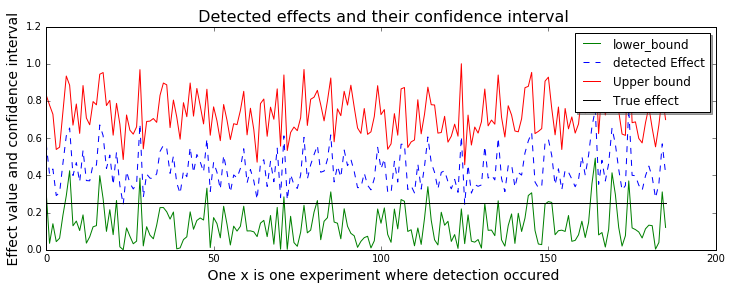

In [66]:
#--------------  plot ------------------------------#
mu = prmtrs['mu']
x = np.arange(Nexp)
xd = np.arange(detect.sum())
mu_line = np.ones((Nexp,))*prmtrs['mu']

# print the number of lower confidence interval values that are above the true mean:
# this should be about the risk of error/2
print("lCI > mu :  {:.3}, compare with {:.3} ".format( 
                (lCI > mu).sum() / (1.*detect.sum()),  prmtrs['alpha'])) #
print(Nexp)
# there should be none of these:
# print "(lCI < 0 ", (lCI[detect] < 0).sum() / detect.sum()

f = plt.figure(1).set_size_inches(12,4)
lines = plt.plot(xd, lCI[detect], 'g-', 
                 xd, effect[detect], 'b--',
                 xd, uCI[detect], 'r-',
                 xd, mu_line[detect], 'k');
plt.legend( lines, ('lower_bound','detected Effect', 'Upper bound', 'True effect'), 
                   loc='upper right', shadow=True)
plt.xlabel(" One x is one experiment where detection occured", fontdict={'size':14})
plt.ylabel(" Effect value and confidence interval ", fontdict={'size':14})
plt.title(" Detected effects and their confidence interval", fontdict={'size':16});

## What happens if ...

### Type I error is stricter 


### sample size goes down